# Background

*Acknowledgement: This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg.*

An excerpt from my Master's thesis 

>The adult human female breast is a bilateral organ located in the skin and subcutaneous tissues of the anterior chest. A woman’s breast is a highly heterogeneous and dynamic organ whose physiological characteristics change constantly over a lifetime based on one’s weight, age, hormone level, habitus, and other factors. Cancer developed therein is referred to as breast cancer in general and it is categorized into a few different types based on its location of origin, cell grade and tumor stage.

While non-invasive detection methods (imaging) are desirable for many different reasons, biopsy is still one of the most reliable techniques that reveals a lot of information about tumors with great accuracy. This project explores a few features obtained from biopsy of ~700 tumors (***benign*** and ***malignant***) in order to construct a model that can classify tumors in their early stages.

It should be noted that the primary goal is not to optimize the accuracy in discriminating between the two tumor classes, but to maximize the true prediction rate for ***benign*** tumors. In this case, as much as **false-positives** (predict as benign while it is malignant) should be avoided because this may cause clinicians to underestimate the situation. On the other hand, **false-negatives** (predict as malignant while it is benign) are somewhat tolerable. This is the opposite of a usual tumor detection problem which tries to detect tumors from non-tumors.

The optimal evaluation metrics for this classification model would be, therefore, ***precision***.

This project explores this dataset through EDA and train *KNN* and *SVM* models to predict the benign tumors with the maximum precision score.


# Data overview and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [3]:
df = pd.read_table('dataset_Breast_Cancer_Wisconsis_Prognostic/breast-cancer-wisconsin.data.txt', sep=',', skiprows=0, header = None)
col_names = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
df.columns = col_names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample code number             699 non-null int64
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


This dataset contains information of 699 tumor cases with 11 columns. In order to understand how each feature has been constructed, the following information can be investigated. 

In [4]:
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
for col in df.columns:
    print('{} unique element: {}'.format(col,df[col].nunique()))

Sample code number unique element: 645
Clump Thickness unique element: 10
Uniformity of Cell Size unique element: 10
Uniformity of Cell Shape unique element: 10
Marginal Adhesion unique element: 10
Single Epithelial Cell Size unique element: 10
Bare Nuclei unique element: 11
Bland Chromatin unique element: 10
Normal Nucleoli unique element: 10
Mitoses unique element: 9
Class unique element: 2


In [6]:
class_perc = (((df['Class'].value_counts())/df['Class'].value_counts().sum()))
print('Dataset is composed of {:.2%} benign and {:.2%} Malignant tumor information'.format(class_perc[2],class_perc[4]))


Dataset is composed of 65.52% benign and 34.48% Malignant tumor information


The first column ***Sample code number*** are the specific label for each biopsy sample tested. This feature should be excluded from the investigation because:
* It is just a sequentially generated number that conveys no information about the tumor itself. 
* A few samples have been tested several times and they may cause undesirable data leakage.

The last column ***Class*** is the data label. 2--> Benign (65.52%) and 4 --> Malignant (34.48%)

Therefore this dataset has 9 features available. Most features are discrete values between 1 and 10, but this dataset has a few missing values that are denoted as **'?'**.
#### Data cleaning for missing values

In [7]:
df_NaN_sum = len(df[df['Bare Nuclei'] == '?'])
df_NaN_pct = df_NaN_sum/df.shape[0]*100
print('# of NaN entries: {}'.format(df_NaN_sum))
print('')
print('% of NaN entries: {:.3f}%'.format(df_NaN_pct))
#print(df_NaN_pct[df_NaN_pct!=0].round(2))

# of NaN entries: 16

% of NaN entries: 2.289%


***Bare Nuclei*** contains 16 missing entries. The ***Bare Nuclei*** score cannot contain decimals, therefore, the missing values may be filled with the *median* of ***Bare Nuclei***. 

In [8]:
df['Bare Nuclei'] = df['Bare Nuclei'].map(lambda x: int(x) if x!='?' else np.nan)
df.fillna({'Bare Nuclei':df['Bare Nuclei'].median()},inplace=True)
df['Bare Nuclei'] = df['Bare Nuclei'].astype('int64')


# Explorative Data Analysis (EDA)
The nine features that this project is exploring are biological parameters. A small change in one may naturally affect the others, and therefore, we may expect to observe strong correlation among them. 
#### Correlation matrix

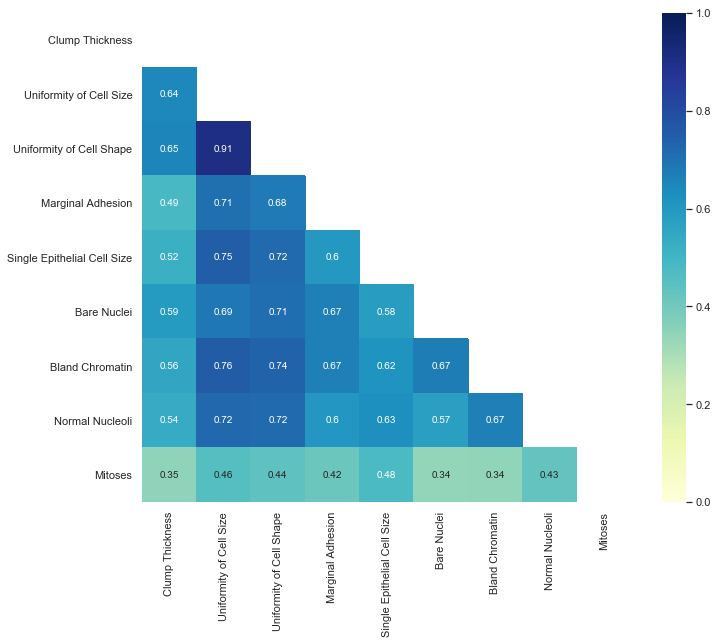

In [9]:
col_feature = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
X = df[col_feature]

corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(11, 9))
ax = sns.heatmap(corr, mask=mask, vmax = 1, vmin = 0, square = True,annot=True,cmap="YlGnBu")
sns.set(font_scale = 1.5)

Based on the correlation matrix, many features are indeed strongly correlated. One thing that was observed was that ***Mitoses*** showed relatively weaker correlation with others. This is somewhat counterintuitive because tumors are known as continuously (abnormally) dividing cells. 

A few random pairs of feature may be investigated further to understand how the different classes of tumor behave against these features.

The values are discrete, so small jitters were added in both x and y axes for better visualization.
#### Random pair comparison

<Figure size 432x288 with 0 Axes>

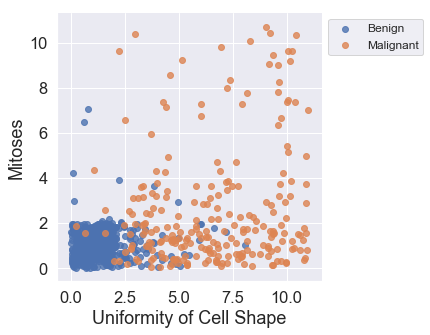

<Figure size 432x288 with 0 Axes>

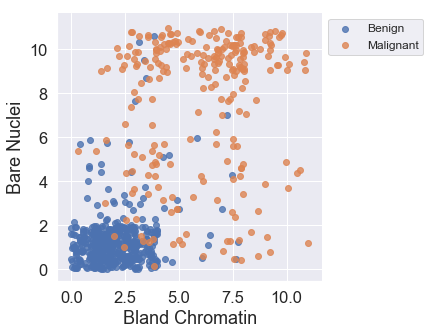

<Figure size 432x288 with 0 Axes>

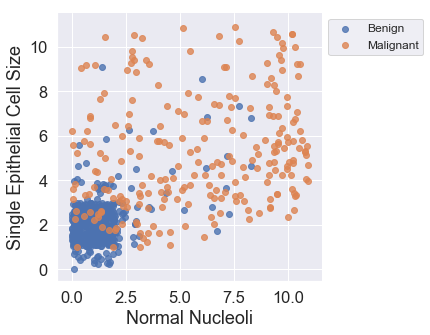

In [10]:
df_EDA = df.copy()
df_EDA['Class'] = np.where(df_EDA['Class'] == 2, 'Benign', 'Malignant')
df_EDA.drop('Sample code number',axis=1,inplace=True)
plt.figure()
sns.lmplot('Uniformity of Cell Shape','Mitoses',fit_reg=False,hue='Class',data=df_EDA,x_jitter=True, y_jitter=True,legend=False)
plt.legend(['Benign','Malignant'],frameon=True,fontsize=12,bbox_to_anchor=(1.0,1), loc="upper left")
plt.figure()
sns.lmplot('Bland Chromatin','Bare Nuclei',fit_reg=False,hue='Class',data=df_EDA,x_jitter=True, y_jitter=True,legend=False)
plt.legend(['Benign','Malignant'],frameon=True,fontsize=12,bbox_to_anchor=(1.0,1), loc="upper left")
plt.figure()
sns.lmplot('Normal Nucleoli','Single Epithelial Cell Size',fit_reg=False,hue='Class',data=df_EDA,x_jitter=True, y_jitter=True,legend=False)
plt.legend(['Benign','Malignant'],frameon=True,fontsize=12,bbox_to_anchor=(1.0,1), loc="upper left")

In oder to observe relationships between all featuers in general, the following pairplot can be investigated. Unfortunately, pairplot does not take random jitters and it looks a bit odd because a lot of data points are overlapped.
#### General pairplot

<Figure size 432x288 with 0 Axes>

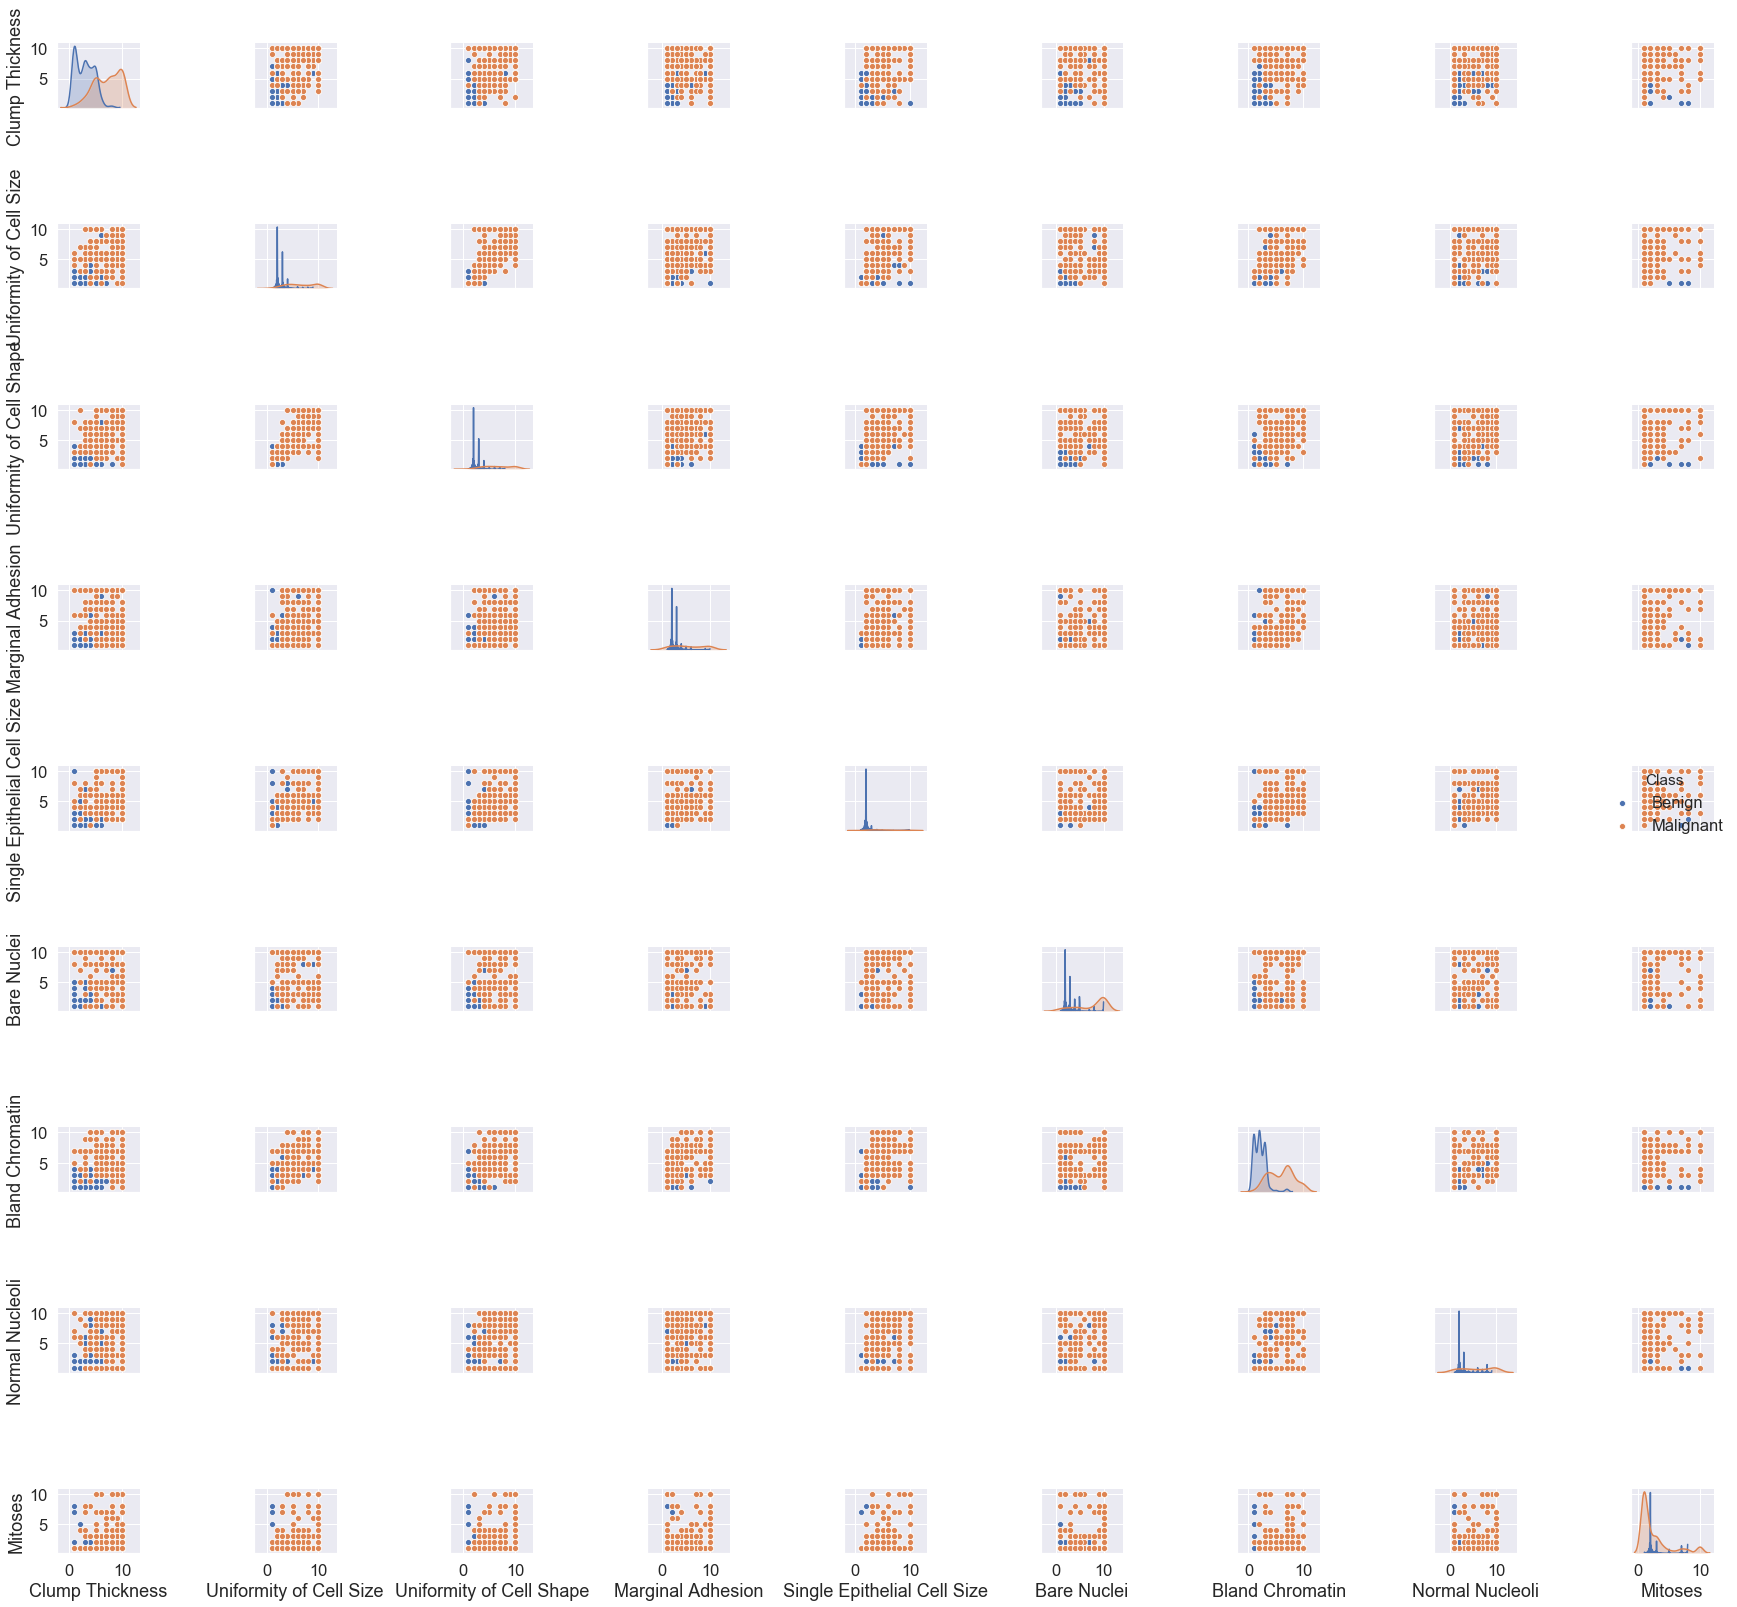

In [11]:
plt.figure()
sns.pairplot(df_EDA,hue='Class')
plt.tight_layout()
plt.show()

This was useful to extract the following important facts.
* Beningn tumors are forming a small cluster in 1D (diag: KDE) and 2D (off-diag) feature spaces.
* Malignant tumors do not form such clusters, but may still be differeniated from their benign counterparts.
#### t-SNA analysis

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
X = df_EDA.drop('Class',axis=1).astype('float') #subject feature cause data leakage
y = df_EDA['Class']

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
tsne = TSNE(random_state=100,verbose=1,perplexity=100)
X_scaled_tsne = tsne.fit_transform(X_scaled)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 699 samples in 0.001s...
[t-SNE] Computed neighbors for 699 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 699 / 699
[t-SNE] Mean sigma: 0.508129
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.184597
[t-SNE] KL divergence after 1000 iterations: 0.406351


In [13]:
df_tsna = pd.concat([pd.DataFrame(X_scaled_tsne,columns=['tsna_0','tsna_1']),y.reset_index(drop=True)],axis=1)

Text(0.5, 1.0, 't-SNE plot by motion')

<Figure size 432x288 with 0 Axes>

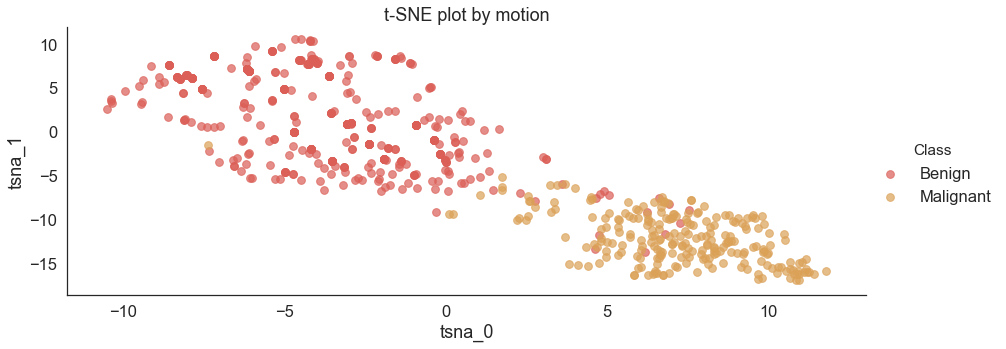

In [14]:
sns.set_style("white")
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='Class',fit_reg=False,scatter_kws={'alpha':0.7,"s": 60},
           data=df_tsna,aspect=2.5,palette=sns.color_palette("hls", 12))
plt.title('t-SNE plot by motion')

From the t-SNE figures, it seems like the two classes tumors are well separated.

# ML model fitting
Dataset is separated into __X__ and **y** as input features and output, respectively.
**y** label is transformed as: 
* 2 -> 1 (Benign)
* 4 -> 0 (Malignant)

In [15]:
df['Class'] = np.where(df['Class'] == 2, 1, 0)
X = X
y = df['Class']

## Baseline study: Dummy classifier
Dummy classifier with `most_frequent` strategy simply predict all as benign. The generated metrics may serve as a good reference when evaluating the performance of the actual models. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
dummy_clf = DummyClassifier(strategy='most_frequent',random_state = 100).fit(X_train,y_train)
y_dummy_predicted = dummy_clf.predict(X_test)
print('Dummy classifier accuracy: {:.2f}'.format(accuracy_score(y_test,y_dummy_predicted)))
print('Dummy classifier recall: {:.2f}'.format(recall_score(y_test,y_dummy_predicted)))
print('Dummy classifier precision: {:.2f}'.format(precision_score(y_test,y_dummy_predicted)))
print('Dummy classifier f1: {:.2f}'.format(f1_score(y_test,y_dummy_predicted)))

Dummy classifier accuracy: 0.60
Dummy classifier recall: 1.00
Dummy classifier precision: 0.60
Dummy classifier f1: 0.75


Since the proprtion of benign tumors in the entire dataset is ~65.5%, these results from the dummay classifier seem reasonable. While it shows a perfect recall score, this is not a good classifier for the prupose of this project because its precision is low.

## Model#1: K-Nearest Neighbors (KNN)
This project is dealing with ~700 data and 9 features. Also, based on EDA performed, it seems like benign tumors form a small cluster with small number of outliers in each feature space. For these reasons, *KNN* is expected to fit the data well with high precision.

The features are within the same scale range, therefore no normalization would be necessary.
#### Parameter selection using 5-fold CV evaluation

Accuracy: 0.981 with K = 4
Recall: 0.989 with K = 40
Precision: 0.994 with K = 2
f1: 0.986 with K = 4


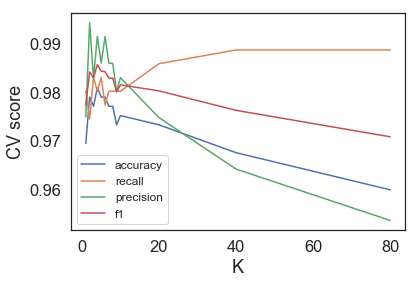

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

param_grid_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,40,80]}
grid_knn_acc = GridSearchCV(KNeighborsClassifier(),param_grid_knn,cv=5,scoring='accuracy').fit(X_train,y_train)
grid_knn_rec = GridSearchCV(KNeighborsClassifier(),param_grid_knn,cv=5,scoring='recall').fit(X_train,y_train)
grid_knn_pre = GridSearchCV(KNeighborsClassifier(),param_grid_knn,cv=5,scoring='precision').fit(X_train,y_train)
grid_knn_f1 = GridSearchCV(KNeighborsClassifier(),param_grid_knn,cv=5,scoring='f1').fit(X_train,y_train)
    
print('Accuracy: {:.3f} with K = {}'.format(grid_knn_acc.best_score_,grid_knn_acc.best_params_['n_neighbors']))
print('Recall: {:.3f} with K = {}'.format(grid_knn_rec.best_score_,grid_knn_rec.best_params_['n_neighbors']))
print('Precision: {:.3f} with K = {}'.format(grid_knn_pre.best_score_,grid_knn_pre.best_params_['n_neighbors']))
print('f1: {:.3f} with K = {}'.format(grid_knn_f1.best_score_,grid_knn_f1.best_params_['n_neighbors']))

plt.figure()
plt.plot(list(param_grid_knn.values())[0],grid_knn_acc.cv_results_['mean_test_score'],label='accuracy')
plt.plot(list(param_grid_knn.values())[0],grid_knn_rec.cv_results_['mean_test_score'],label='recall')
plt.plot(list(param_grid_knn.values())[0],grid_knn_pre.cv_results_['mean_test_score'],label='precision')
plt.plot(list(param_grid_knn.values())[0],grid_knn_f1.cv_results_['mean_test_score'],label='f1')
plt.xlabel('K')
plt.ylabel('CV score')
plt.legend(fontsize=12)


While all metrics are high, **K=2** seems to maximize the precision score as **0.994**.
However, the optimal K parameter may change depending on the `random_state` of the `test_train_split`. In real case, this approach should be **avoided** as this would cause data leakage. For this project, the following investigation is done just out of my curiosity.
#### OPTIONAL: Testing 4 randomly chosen random_state to optimize 5-fold CVprecision score of the model

At random split 520: Max precision score = 0.997 at K = 4
At random split 792: Max precision score = 0.991 at K = 2
At random split 835: Max precision score = 0.994 at K = 2
At random split 871: Max precision score = 0.985 at K = 4


Text(0, 0.5, 'CV precision score')

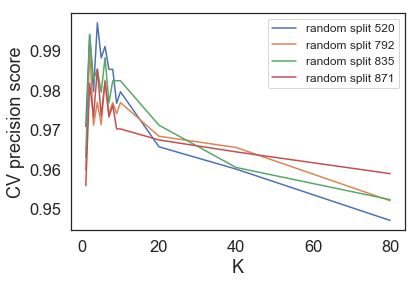

In [18]:
plt.figure()
np.random.seed(100)
for r in np.random.randint(0,1000,4).tolist():
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=r)
    param_grid = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,40,80]}
    grid_knn_pre = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,scoring='precision').fit(X_train,y_train)
    plt.plot(list(param_grid.values())[0],grid_knn_pre.cv_results_['mean_test_score'],label=('random split '+str(r)))
    print('At random split {}: Max precision score = {:.3f} at K = {}'.format(r,grid_knn_pre.best_score_,grid_knn_pre.best_params_['n_neighbors']))
plt.legend(fontsize=12)
plt.xlabel('K')
plt.ylabel('CV precision score')

#### OPTIONAL: 
Based on the graph obtained obove, it is the model either K=2 or K=4 that is expected to generate the optimal precision score. Interestingly, when K=3, the precision score drops in all different cases. Now the range is shirnked, more intense search can be followed.

In [19]:
np.random.seed(100)
K_2 = []
K_4 = []
K_else = []
n_testing = 100
for r in np.random.randint(0,1000, n_testing):
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=r)
    grid_knn_pre = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,scoring='precision',iid=True).fit(X_train,y_train)
    if grid_knn_pre.best_params_['n_neighbors'] == 2:
        K_2.append(grid_knn_pre.best_score_)
    elif grid_knn_pre.best_params_['n_neighbors'] == 4:
        K_4.append(grid_knn_pre.best_score_)
    else:
        K_else.append(grid_knn_pre.best_score_)
print('Out of '+ str(n_testing) + 'random shuffle:')
print('K=2 recorded max precision scores {} times with mean {}'.format(str(len(K_2)),np.mean(K_2).round(3)))
print('K=4 recorded max precision scores {} times with mean {}'.format(str(len(K_4)),np.mean(K_4).round(3)))
print('K=others recorded max precision scores {} times with mean {}'.format(str(len(K_else)),np.mean(K_else).round(3)))

Out of 100random shuffle:
K=2 recorded max precision scores 68 times with mean 0.992
K=4 recorded max precision scores 25 times with mean 0.99
K=others recorded max precision scores 7 times with mean 0.99


#### OPTIONAL:
For such a small difference in the precision socre, this step was possibly not necessary. Nonetheless, **K=2** turned out to be the one that generally maximize the CV precision socre. Fortunately, this (with data leakage) generated the same result as the CV evaluation without data leakage.  

#### Back to 5-fold CV evaluation:
The constructed KNN model is shown to detect benign tumors with 0.994 precision on CV set. While 0.994 precision score is quite high, in this case, 1.00 precision score is desirable by avoiding all possible *false positives*.

For this purpose, various probablisitic threshold can be tested on CV to see if any threshold (other than default 0.5) would decrease false positives.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train,y_train)
y_train_prob = cross_val_predict(knn, X_train, y_train, cv=52, method='predict_proba')[:,1]

for t in np.arange(0.2,0.7,0.1):
    y_train_predicted = [1 if y >= t else 0 for y in y_train_prob]
    print('when threshold is:' + str(t.round(2)))
    print(pd.DataFrame(confusion_matrix(y_train,y_train_predicted),index=['-','+'],columns=['pred-','pred+']))

when threshold is:0.2
   pred-  pred+
-    151     20
+      5    348
when threshold is:0.3
   pred-  pred+
-    151     20
+      5    348
when threshold is:0.4
   pred-  pred+
-    151     20
+      5    348
when threshold is:0.5
   pred-  pred+
-    167      4
+      9    344
when threshold is:0.6
   pred-  pred+
-    167      4
+      9    344


So, it turned out that increasing the probablistic threshold beyond the default of 0.5 does not help improving the result. Now, the fitted model can be applied to the test set to report the model performance.

#### Performance of the model on the test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train,y_train)
y_predicted = knn.predict(X_test)

print('Test set scores of KNN with K = 2:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test,y_predicted)))
print('Recall: {:.3f}'.format(recall_score(y_test,y_predicted)))
print('Precision: {:.3f}'.format(precision_score(y_test,y_predicted)))
print('f1: {:.3f}'.format(f1_score(y_test,y_predicted)))
print('\nconfusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test,y_predicted),index=['-','+'],columns=['pred-','pred+']))

Test set scores of KNN with K = 2:
Accuracy: 0.954
Recall: 0.933
Precision: 0.990
f1: 0.961

confusion matrix:
   pred-  pred+
-     69      1
+      7     98


The constructed KNN model is shown to differentiate ***benign*** tumors from its ***malignant*** counterparts with **0.990** precision.

## Model#2: Support Vector Classifier (SVC)
#### Parameter selection using 5-fold CV evaluation

In [22]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

param_grid_svc = [{'kernel':['linear'],'C':[0.1, 1, 10, 100]},
              {'kernel':['rbf'],'C':[0.1,1,10,100],'gamma':[0.01,0.1,1]}]
grid_svc_acc = GridSearchCV(SVC(),param_grid_svc,cv=5,scoring='accuracy').fit(X_train,y_train)
grid_svc_rec = GridSearchCV(SVC(),param_grid_svc,cv=5,scoring='recall').fit(X_train,y_train)
grid_svc_pre = GridSearchCV(SVC(),param_grid_svc,cv=5,scoring='precision').fit(X_train,y_train)
grid_svc_f1 = GridSearchCV(SVC(),param_grid_svc,cv=5,scoring='f1').fit(X_train,y_train)

score_ser = pd.Series({'accuracy':grid_svc_acc.best_score_,'recall':grid_svc_rec.best_score_,
              'precision':grid_svc_pre.best_score_,'f1':grid_svc_f1.best_score_},name='Best CV score')
pd.concat([pd.DataFrame([grid_svc_acc.best_params_,grid_svc_rec.best_params_,grid_svc_pre.best_params_,grid_svc_f1.best_params_],
            index = ['accuracy','recall','precision','f1']),score_ser.round(3)],axis=1)

,C,gamma,kernel,Best CV score
accuracy,0.1,NaN,linear,0.979
recall,0.1,1.0,rbf,1.000
precision,0.1,0.1,rbf,1.000
f1,0.1,NaN,linear,0.984


From the `GridSeachCV` result, *kernel = rbf, C = 0.1, gamma = 0.1* showed the highest 5-fold CV precision score of **1.00**. As this is very satisfactory, this model can be fitted and evaluated on test set to report the model performance.

In [23]:
svc = SVC(kernel = 'rbf', C = 0.1, gamma = 0.1).fit(X_train,y_train)
y_predicted = svc.predict(X_test)
y_score = svc.decision_function(X_test)

print('Test set scores of SVC with kernel = rbf, C = 0.1, gamma = 0.1:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test,y_predicted)))
print('Recall: {:.3f}'.format(recall_score(y_test,y_predicted)))
print('Precision: {:.3f}'.format(precision_score(y_test,y_predicted)))
print('f1: {:.3f}'.format(f1_score(y_test,y_predicted)))
print('\nconfusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test,y_predicted),index=['-','+'],columns=['pred-','pred+']))

Test set scores of SVC with kernel = rbf, C = 0.1, gamma = 0.1:
Accuracy: 0.931
Recall: 0.886
Precision: 1.000
f1: 0.939

confusion matrix:
   pred-  pred+
-     70      0
+     12     93


Even on the test set, this SVC model differentiated ***benign*** tumors from ***benign*** with a **perfect precision**. Of course, its recall has been compromised a bit due to their natural trade-off. This can be seen in its precision-recall curve below.
#### precision-recall curve

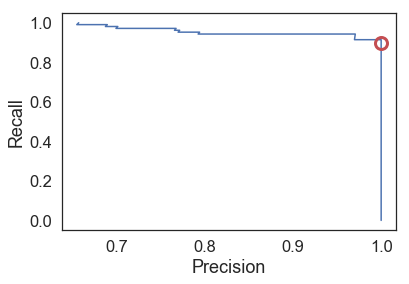

In [24]:
pre, rec, thrsh = precision_recall_curve(y_test,y_score)

plt.plot(pre, rec)
plt.xlabel('Precision');
plt.ylabel('Recall');

closest_zero = np.argmin(np.abs(thrsh))
closest_zero_p = pre[closest_zero]
closest_zero_r = rec[closest_zero]
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)


# Conclusion

This summarizes the project. While this was the real case dataset, the two models constructed showed **extremely high precision (1.00)** scores on their test sets (compromising its recall to some degrees). This was expected from EDA as the benign tumors formed clear clusters in each of the feature space explored.

In each model, the optimal parameter(s) were searched up through 5-fold CV evaluations. Nonetheless, the KNN model was less precise than the SVC (with rbf kernel) model by 1%, possibly due to the presence of some outliers in the training set.

With a large dataset (>~50k), the performance of SVC may decrease in terms of training speed and memory. As the size of this dataset is relatively small, SVC was performing well with great precision. Therefore, it may not be necessary to test other models that are more sophisticated and computationally expensive. 